In [425]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [426]:
#Функция для перевода строки новых ненормализованных данных в строку нормализованных
# features здесь это только числовые параметры, в том же порядке в котором они записаны в scaler (а значит в массив "numeric_features")
def new_scaler(features, scale, mean):
    for i in range(len(features)):
        features[i] = (features[i] - mean[i])/ scale[i]
    return features

#Функция для перевода строки нормализованных данных в первоночальный вид
def scaled_to_normal(features, scale, mean):
    for i in range(len(features)):
        features[i] = features[i] * scale[i] + mean[i]
    return features


In [427]:
#Чтение данных

data = pd.read_csv('train_short.csv')
# Показать названия всех столбцов
print("\nНазвания столбцов:")
print(data.columns.tolist())

# Показать первые несколько строк
print("\nПервые 2 строк данных:")
print(data.head(2))


Названия столбцов:
['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

Первые 2 строк данных:
   id Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   0   Male   21                1         35.0                   0   
1   1   Male   43                1         28.0                   0   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year            Yes         65101.0                 124.0      187   
1   > 2 Years            Yes         58911.0                  26.0      288   

   Response  
0         0  
1         1  


In [428]:
# Удаляем строки с пропущенными значениями (их нет)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000001 entries, 0 to 5000000
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 457.8+ MB


In [429]:
#Оставляем только нужные столбцы
#columns_to_keep = ['Response', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
columns_to_keep = ['Response', 'Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel']
data = data[columns_to_keep]

In [430]:
# One-hot кодирование категориальных признаков
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Driving_License', 'Previously_Insured']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

length = len(data)


In [431]:
# Нормализация числовых признаков
#numeric_features = ["Age", 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
numeric_features = ["Age", 'Annual_Premium', 'Policy_Sales_Channel']
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [432]:
scaler.scale_

array([1.49967598e+01, 1.64761977e+04, 5.40481829e+01])

In [433]:
scaler.mean_

array([   38.38755612, 30468.54795689,   112.40399492])

In [434]:
#Функция для удаления выбросов. Проверяем только численные значения
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    #Можно тут поиграться с коэффициентом на который умножается
    lower_bound = Q1 - 1.6 * IQR
    upper_bound = Q3 + 1.6 * IQR
    
    return df[(df[column] >= lower_bound) & 
             (df[column] <= upper_bound)]

data_clean = data
#Удаление выбросов
for col in data_clean.select_dtypes(include=['float64']).columns:
    data_clean = remove_outliers_iqr(data_clean, col)

print("Строчек удалено: ", len(data) - len(data_clean))
print(len(data_clean))
print(len(data))

Строчек удалено:  92550
4907451
5000001


In [435]:
data = data_clean

In [436]:
#Данные несбалансированные
data.Response.value_counts()

Response
0    4306727
1     600724
Name: count, dtype: int64

In [437]:
data.head()

,Response,Age,Annual_Premium,Policy_Sales_Channel,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Driving_License_1,Previously_Insured_1
1,1,0.307563,1.726275,-1.598648,True,False,True,True,True,False
2,0,-0.892697,0.459721,0.732606,False,True,False,False,True,True
3,0,-0.225886,-1.689622,0.806614,False,False,False,True,True,False
4,0,-0.159205,0.089975,0.732606,False,False,False,False,True,True
5,0,-0.492610,-0.140721,0.732606,False,True,False,False,True,True


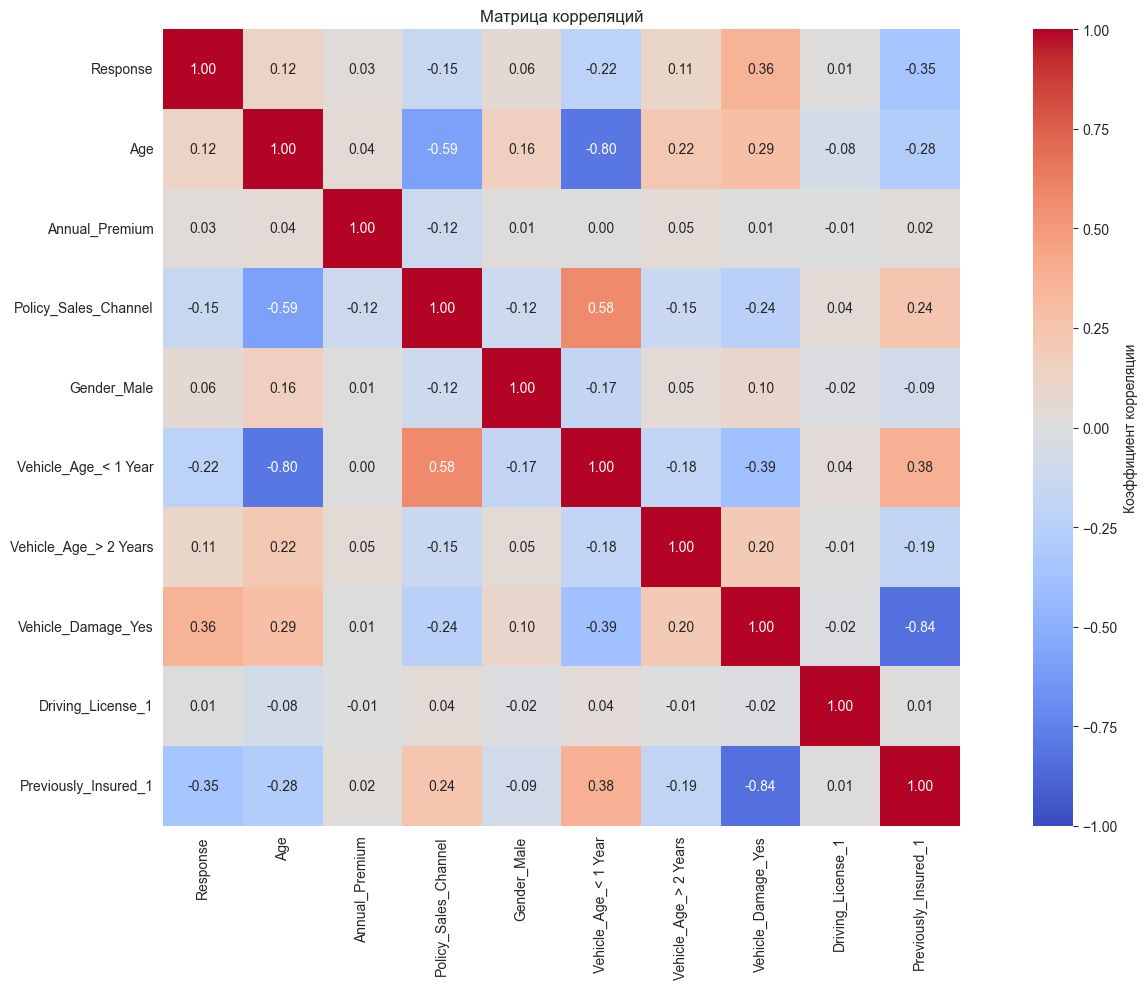

In [438]:
# Вычисляем корреляционную матрицу
corr_matrix = data.corr()

# Настраиваем график
plt.figure(figsize=(15, 10))
sns.set_style("white")

# Создаем тепловую карту
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Коэффициент корреляции'},
    #annot_kws={'fontsize': 8}
)

plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

In [ ]:
# Разделение на признаки (X) и целевую переменную (y)
X = data.drop('Response', axis=1)
y = data['Response']

# Разделение на обучающую и тестовую выборки. Только для проверки PCA, потом надо заменить на кросс-валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

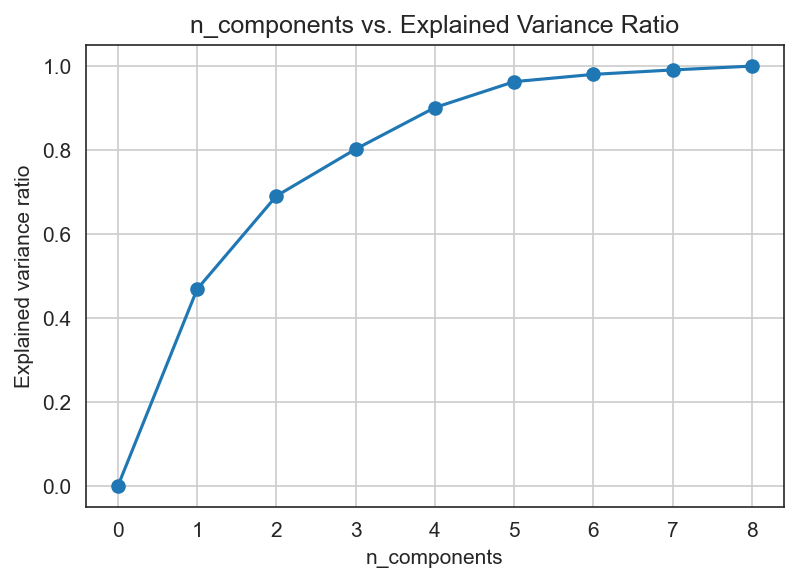

In [440]:
# Выбор оптимального количества компонент для PCA
nums = np.arange(X_train.shape[1])

var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_train)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))


plt.figure(figsize=(6,4),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

Доля объясненной дисперсии для каждого фактора:
Фактор 1: 46.87%
Фактор 2: 22.18%
Фактор 3: 11.15%
Фактор 4: 9.89%
Фактор 5: 6.16%
Фактор 6: 1.73%

Доля общей дисперсии: 0.9797667669918001


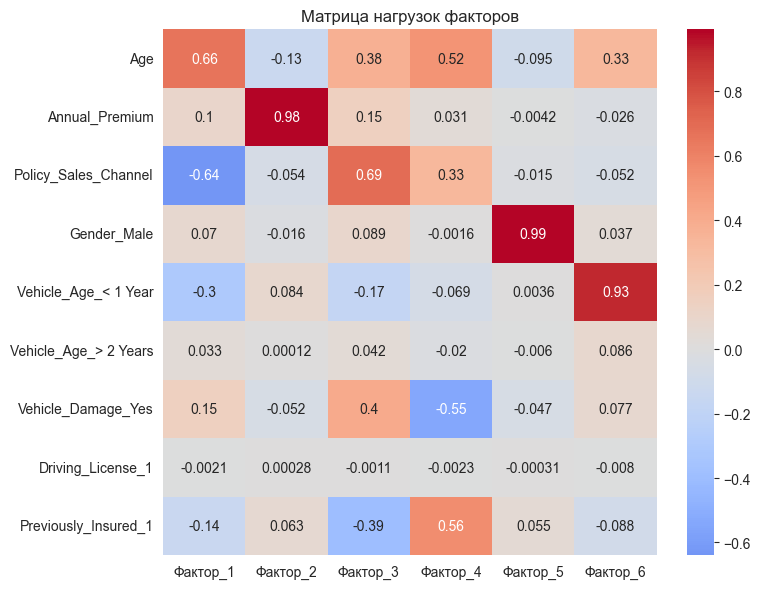

In [441]:
n = 6
# Создаем объект PCA с n компонентами
pca = PCA(n_components=n)

# Применяем PCA к данным
pca_data = pca.fit_transform(X_train)

# Создаем DataFrame с результатами
pca_df = pd.DataFrame(
    pca_data,
    columns=[f'Фактор_{i+1}' for i in range(n)]
)

# Добавляем исходные признаки
pca_df = pd.concat([pca_df, X_train], axis=1)

# Выводим объясненную дисперсию
print("Доля объясненной дисперсии для каждого фактора:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"Фактор {i}: {var:.2%}")

print(f"\nДоля общей дисперсии: {sum(pca.explained_variance_ratio_)}")

""""
# Визуализируем вклад каждого фактора
plt.figure(figsize=(8, n+1))
plt.bar(range(1, n+1), pca.explained_variance_ratio_)
plt.title('Доля объясненной дисперсии по факторам')
plt.xlabel('Номер фактора')
plt.ylabel('Доля дисперсии')
plt.show()
"""


# Анализируем вклад исходных признаков в факторы
components = pd.DataFrame(
    pca.components_.T,
    columns=[f'Фактор_{i+1}' for i in range(n)],
    index=X.columns
)

# Визуализируем матрицу нагрузок
plt.figure(figsize=(8, 6))
sns.heatmap(components, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица нагрузок факторов')
plt.tight_layout()
plt.show()

In [ ]:
# Просто смотрю как в целом обучать модель используя pca. Потом уберем
# Не советую расскоментировать тк на 5миллионах данных считается очень долго, я на меньшем количестве проверяла и оно работает

"""
X_train = pca.fit_transform(X_train)

knn_param_grid = {'n_neighbors': [3]}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
knn_model.fit(X_train, y_train)

X_test = pca.fit_transform(X_test)
y_pred = knn_model.predict(X_test)
# Отчет классификации
print(classification_report(y_test, y_pred))
"""

'\nX_train = pca.fit_transform(X_train)\n\nknn_param_grid = {\'n_neighbors\': [3]}\nknn_model = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)\nknn_model.fit(X_train, y_train)\n\nX_test = pca.fit_transform(X_test)\ny_pred = knn_model.predict(X_test)\n# Отчет классификации\nprint(classification_report(y_test, y_pred))"\n'